# Notebook 024: Logistic Classifier Models using final predictor set

This notebook contains a baseline crime-type classifier model using an initial set of property-related predictors.

The response variable is:

       'crime-type'

Features used in this initial baseline model include:

       'commercial-mix-ratio', 'industrial-mix-ratio', 'owner-occupied-ratio',
       'residential-median-value', 'residential-gini-coef',
       'industrial-mix-ratio-3yr-cagr', 'commercial-mix-ratio-3yr-cagr',
       'owner-occupied-ratio-3yr-cagr', 'residential-median-value-3yr-cagr',
       'residential-gini-coef-3yr-cagr', 'Tuesday', 'Wednesday', 'Thursday',
       'Friday', 'Saturday', 'Sunday', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
       'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'night'

The baseline models tested are Multi-class Logistic Regression Models with and without regularization.

In [1]:
import urllib
import os
import operator
import pathlib
import requests
from joblib import dump, load
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LassoCV

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import statsmodels.api as sm

from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
DATA_ROOT = '../data/'
FIGURES_ROOT = '../figures/model-logistic'
WRITEDIR_ROOT = '../models/logistic'

READDIR_ROOT = os.path.join(DATA_ROOT, 'processed')
SHAPEDIR_ROOT = os.path.join(DATA_ROOT, 'raw')

readfile_model_X = os.path.join(READDIR_ROOT, 'X_train.csv')
readfile_model_X_scaled = os.path.join(READDIR_ROOT, 'X_train_scaled.csv')
readfile_model_y = os.path.join(READDIR_ROOT, 'y_train.csv')
readfile_model_X_test = os.path.join(READDIR_ROOT, 'X_test.csv')
readfile_model_X_test_scaled = os.path.join(READDIR_ROOT, 'X_test_scaled.csv')
readfile_model_y_test = os.path.join(READDIR_ROOT, 'y_test.csv')
readfile_model_X_scaler = os.path.join(READDIR_ROOT, 'X_scaler.csv')

readfile_zipshapes = os.path.join(SHAPEDIR_ROOT, 'shapefile/zipcodes/ZIP_Codes.shp')
readfile_cityshape = os.path.join(SHAPEDIR_ROOT, 'shapefile/city-boundary/City_of_Boston_Boundary.shp')
readfile_streetshapes = os.path.join(SHAPEDIR_ROOT, 'shapefile/street-segments/Boston_Street_Segments.shp')
readfile_tractshapes = os.path.join(SHAPEDIR_ROOT, 'shapefile/census-tracts/Census_2010_Tracts.shp')
readfile_hoodshapes = os.path.join(SHAPEDIR_ROOT, 'shapefile/boston-neighborhoods/Boston_Neighborhoods.shp')
readfile_zonesubshapes = os.path.join(SHAPEDIR_ROOT, 'shapefile/zoning-subdistricts/Zoning_Subdistricts.shp')
readfile_openshapes = os.path.join(SHAPEDIR_ROOT, 'shapefile/open-spaces/Open_Space.shp')

print(
    'readfile paths for datasets used in this notebook are:\n\t{}\n\t{}\n\t{}\n\t{}\n'.format(
        readfile_model_X, readfile_tractshapes, FIGURES_ROOT, WRITEDIR_ROOT
    )
)

readfile paths for datasets used in this notebook are:
	../data/processed/X_train.csv
	../data/raw/shapefile/census-tracts/Census_2010_Tracts.shp
	../figures/model-logistic
	../models/logistic



In [3]:
# mkdir for saving figures if it doesn't already exist
if not os.path.exists(FIGURES_ROOT):
    os.mkdir(FIGURES_ROOT)
    
# mkdir for saving output data if it doesn't already exist
if not os.path.exists(WRITEDIR_ROOT):
    os.mkdir(WRITEDIR_ROOT)

## Read labeled training and TEST data and subset predictors and response variable

In [4]:
# read in labeled model data
X_train_labels = pd.read_csv(readfile_model_X)
X_train_scaled_labels = pd.read_csv(readfile_model_X_scaled)
y_train_labels = pd.read_csv(readfile_model_y)

X_test_labels = pd.read_csv(readfile_model_X_test)
X_test_scaled_labels = pd.read_csv(readfile_model_X_test_scaled)
y_test_labels = pd.read_csv(readfile_model_y_test)

# read in scaled data scaling parameters to restore scaled values if needed
X_scaler = pd.read_csv(readfile_model_X_scaler)

In [5]:
# subset X and Y data to include only the columns used for model training
predictor_columns = list(X_train_labels.iloc[:,17:].columns)
response_column = ['crime-type']

X_train = X_train_labels[predictor_columns].copy()
X_train_scaled = X_train_scaled_labels[predictor_columns].copy()
y_train = y_train_labels[response_column].values.ravel()

X_test = X_test_labels[predictor_columns].copy()
X_test_scaled = X_test_scaled_labels[predictor_columns].copy()
y_test = y_test_labels[response_column].values.ravel()

In [6]:
# summarize dataframe info
print('Y TRAIN DATA WITH ADDITIONAL LABELS\n')
y_train_labels.info()
print('\n\nX TRAIN DATA WITH ADDITIONAL LABELS\n')
X_train_labels.info()
print('\n\nX TRAIN PREDICTORS (WITH LABEL COLUMNS EXCLUDED)\n')
print(predictor_columns)
print('\n\nTHE SHAPE OF THE X AND Y TRAIN FRAMES WITH PREDICTORS ONLY\n')
print(X_train.shape)
print(X_train_scaled.shape)
print(y_train.shape)
print('\n\nX SCALER DATA INFO\n')
X_scaler.info()
print(
    '\n\nTHE X SCALER DATA CONTAINS MEANS AND STDS FOR THE FOLLOWING STANDARDIZED '\
    '(i.e. SCALED) PREDICTORS\n\n{}'.format(X_scaler['scaled-feature'].values)
)

Y TRAIN DATA WITH ADDITIONAL LABELS

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128352 entries, 0 to 128351
Data columns (total 4 columns):
crime-type             128352 non-null int64
crime-type-cat         128352 non-null object
OFFENSE_DESCRIPTION    128352 non-null object
INCIDENT_NUMBER        128352 non-null object
dtypes: int64(1), object(3)
memory usage: 3.9+ MB


X TRAIN DATA WITH ADDITIONAL LABELS

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128352 entries, 0 to 128351
Data columns (total 60 columns):
date                                 128352 non-null object
year                                 128352 non-null int64
month                                128352 non-null int64
hour                                 128352 non-null int64
time                                 128352 non-null int64
ZIP5                                 128352 non-null int64
ZIP5_area                            128352 non-null float64
Name                                 128352 non-null o

In [7]:
# create lists of predictors based on numeric type for easier treatment of specific types
predictors_binary = [
    'night', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday',
    'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 
    'college-near', 'highschool-near'
]
predictors_nonbinary = [col for col in X_train.columns if col not in predictors_binary]
predictors_discrete = [
    'streetlights-night',
    'median-age',
]
predictors_continuous = [col for col in predictors_nonbinary if col not in predictors_discrete]

print(
    'Binary predictors in the X training data are:\n\n{}\n\n\n'\
    'Non-binary predictors are:\n\n{}\n\n\n'\
    'Of the non-binary, the following are discrete:\n\n{}\n\n\n'\
    'And these remaining are continuous:\n\n{}\n'.format(
        predictors_binary,
        predictors_nonbinary,
        predictors_discrete,
        predictors_continuous
    )
)

Binary predictors in the X training data are:

['night', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'college-near', 'highschool-near']


Non-binary predictors are:

['streetlights-night', 'lat', 'lon', 'tempavg', 'windavg', 'precip', 'snowfall', 'median-age', 'median-income', 'poverty-rate', 'less-than-high-school-perc', 'bachelor-degree-or-more-perc', 'enrolled-college-perc', 'commercial-mix-ratio', 'industrial-mix-ratio', 'owner-occupied-ratio', 'residential-median-value', 'residential-gini-coef', 'commercial-mix-ratio-3yr-cagr', 'industrial-mix-ratio-3yr-cagr', 'owner-occupied-ratio-3yr-cagr', 'residential-gini-coef-3yr-cagr', 'residential-median-value-3yr-cagr']


Of the non-binary, the following are discrete:

['streetlights-night', 'median-age']


And these remaining are continuous:

['lat', 'lon', 'tempavg', 'windavg', 'precip', 'snowfall', 'median-income', 'poverty-rate', 'less

## Inspect multi-collinearity of predictors

In [8]:
def sort_pairwise_correlation(X_train):
    """
    Calculates a correlation matrix of all input predictors and observations,
    via the X_train dataframe, then returns a sorted dataframe of all
    pairwise correlation values (duplicates and same-value pairings removed).
    
    The returned sorted correlation summary dataframe is sorted in descending
    order, from highest to lowest correlation pairings.
    """
    # calculate correlation among all predictors
    correlation_matrix_df = X_train.corr()
    correlation_abs_matrix_df = X_train.corr().abs()

    # identify variables most heavily correlated in descending order
    # and remove pairwise groupings of the same predictors
    corr_unstack = correlation_abs_matrix_df.unstack()
    corr_sorted = corr_unstack.sort_values(ascending=False)
    corr_sorted = corr_sorted[corr_sorted < 1][::2]
    
    return corr_sorted


In [9]:
#############################################
## Calculate and report on pairwise correlations
#############################################

# generate sorted correlation dataframe
corr_df = sort_pairwise_correlation(X_train)

# set corr threshold for reporting
corr_thresh = 0.50

print(
    '\nThe most strongly correlated predictors (corr > {0:.2f}) in our baseline model '\
    'predictor set and their corresponding correlation values are:\n\n{1}\n'.format(
        corr_thresh,
        corr_df[corr_df > corr_thresh],
    )
)


The most strongly correlated predictors (corr > 0.50) in our baseline model predictor set and their corresponding correlation values are:

poverty-rate                  median-income                   0.832140
bachelor-degree-or-more-perc  less-than-high-school-perc      0.829621
night                         streetlights-night              0.814221
enrolled-college-perc         bachelor-degree-or-more-perc    0.775921
owner-occupied-ratio          enrolled-college-perc           0.735861
median-age                    owner-occupied-ratio            0.726905
residential-gini-coef         residential-median-value        0.719481
median-income                 less-than-high-school-perc      0.718383
bachelor-degree-or-more-perc  median-income                   0.714370
                              residential-gini-coef           0.672335
college-near                  enrolled-college-perc           0.670402
poverty-rate                  median-age                      0.668691
enrolled

## Create value count summary tables by crime-type for later reference

In [10]:
agg_dict = {'INCIDENT_NUMBER': 'count'}

crime_types_train = y_train_labels.groupby(
    ['crime-type', 'crime-type-cat']
).agg(agg_dict).rename(columns=agg_dict)

crime_types_train['proportion'] = crime_types_train / crime_types_train.sum()

crime_types_test = y_test_labels.groupby(
    ['crime-type', 'crime-type-cat']
).agg(agg_dict).rename(columns=agg_dict)

crime_types_test['proportion'] = crime_types_test / crime_types_test.sum()

# create dictionary of crime types for later use
class_dict = dict(
    zip(crime_types_test.reset_index()['crime-type'], crime_types_test.reset_index()['crime-type-cat'])
)

In [11]:
class_dict

{0: 'other',
 1: 'burglary',
 2: 'drugs-substances',
 3: 'fraud',
 4: 'harassment-disturbance',
 5: 'robbery',
 6: 'theft',
 7: 'vandalism-property',
 8: 'violence-aggression'}

In [12]:
print(
    'The number of observed crime type classes in both the training and test set are:\n\n'\
    'TRAINING\n{}\n\n\nTEST\n{}\n'.format(
        crime_types_train,
        crime_types_test
    )
)

The number of observed crime type classes in both the training and test set are:

TRAINING
                                   count  proportion
crime-type crime-type-cat                           
0          other                    6321    0.049247
1          burglary                 5664    0.044129
2          drugs-substances        13082    0.101923
3          fraud                    9587    0.074693
4          harassment-disturbance  20767    0.161797
5          robbery                  3423    0.026669
6          theft                   34555    0.269221
7          vandalism-property      13710    0.106816
8          violence-aggression     21243    0.165506


TEST
                                   count  proportion
crime-type crime-type-cat                           
0          other                    1580    0.049240
1          burglary                 1416    0.044129
2          drugs-substances         3271    0.101938
3          fraud                    2397    0.074701
4

## Define functions used to generate and evaluate models

In [104]:
####################################################################
# DEFINE FUNCTIONS THAT CONTRIBUTE TO GENERATING A FITTED MODEL DICT 
####################################################################

def summarize_predictions(predictions_train, predictions_test):
    """
    Generates a summary table of the training and test predictions, showing count
    and proportion by class
    
    predictions_train: np.array, the predicted classes generated on the training data
    predictions_test:np.array, the predicted classes generated on the test data
    
    returns: tuple of 2 pd.DataFrame objects, one summarizing the training predictions
             the other summarizing the test predictions
    """
    frame_name_list = ['pred_counts_train', 'pred_counts_test']
    
    for predictions, name in zip(
        [predictions_train, predictions_test],
        frame_name_list
    ):
        locals()[name] = np.array(np.unique(predictions, return_counts=True)).T
        locals()[name] = np.hstack(
            [locals()[name], locals()[name][:,1].reshape(-1,1)/np.sum(locals()[name][:,1])]
        )
        locals()[name] = pd.DataFrame(locals()[name], columns=['class', 'count', 'proportion'])
        locals()[name][['class', 'count']] = locals()[name][['class', 'count']].astype(int)
        locals()[name] = locals()[name].set_index('class')

    return locals()[frame_name_list[0]], locals()[frame_name_list[1]]


def make_conf_matrix(predictions, y_actual):
    """
    Generates a confusion matrix of actual classes versus predicted classes
    
    predictions: np.array, predicted class values generated by the model
    y_actual: np.array, actual class values
    
    returns: pd.DataFrame, the resulting confusion matrix with marginal totals included
    """
    class_labels = sorted(list(set(y_actual)))
    
    conf_matrix = pd.DataFrame(confusion_matrix(predictions, y_actual), columns=class_labels)
    conf_matrix.index.name = 'Predicted'
    conf_matrix.columns.name = 'Actual'
    conf_matrix.loc['Total'] = conf_matrix.sum(axis=0)
    conf_matrix['Total'] = conf_matrix.sum(axis=1)
    
    return conf_matrix


def generate_class_metrics(conf_matrix):
    """
    Generates a dataframe of the various by-class classification metrics that
    can be calculated directly from a confusion matrix, such as True Positive Rate,
    False Negative Rate, etc.
    
    conf_matrix: pd.DataFrame, generated with the make_conf_matrix function
    
    returns: pd.DataFrame, each row representing a different class, each
             column a different classification metric for each class
    """
    # rename index
    conf_matrix = conf_matrix.copy()
    conf_matrix.index.name = 'class'
    conf_matrix.columns.name = 'class'
    results = dict()
    
    # True Pos, False Pos, False Neg, True Neg counts
    results['TP'] = pd.Series(np.diag(conf_matrix.iloc[:-1,:-1]))
    results['TP'].index.name = 'class'
    results['FP'] = conf_matrix.iloc[:-1,:-1].sum(axis=1) - results['TP']  
    results['FN'] = conf_matrix.iloc[:-1,:-1].sum(axis=0) - results['TP']
    results['TN'] = conf_matrix.iloc[:-1,:-1].values.sum() -\
                    (results['FP'] + results['FN'] + results['TP'])

    # true positive rate
    results['TPR'] = results['TP']/(results['TP']+results['FN'])
    # false negative rate
    results['FNR'] = results['FN']/(results['TP']+results['FN'])
    # false positive rate
    results['FPR'] = results['FP']/(results['FP']+results['TN'])
    # true negative rate
    results['TNR'] = results['TN']/(results['TN']+results['FP']) 
    # positive predictive value
    results['PPV'] = results['TP']/(results['TP']+results['FP'])
    # negative predictive value
    results['NPV'] = results['TN']/(results['TN']+results['FN'])
    
    # convert results dictionary to a dataframe 
    results_df = pd.concat(
        [
            # first separate the integer values so they format correctly
            pd.DataFrame(
                list(results.values())[:4],
                index=list(results.keys())[:4]
            ).T,
            # followed by the float values
            pd.DataFrame(
                list(results.values())[4:],
                index=list(results.keys())[4:]
            ).T
        ], axis=1
    )
    
    return results_df


def generate_roc_auc(y_values_actual, predicted_probabilities, class_dict):
    """
    Creates a dictionary of ROC curve values generated using
    sklearn.metrics.roc_curve for every outcome class in a multi-class
    problem
    
    NOTE: multi-class AUC requires scikit-learn>=v0.22

    y_values_actual: np.array, the 1-dimensional array containing the 
                     multi-classs true y values against which you are evaluating
                     the predicted probabilities (i.e. y_test)
    predicted_probabilities: np.array, the 2-dimensional array generated
                             using sklearn's "model.predict_proba()" method
                             (i.e. test set predicted probabilities)
                     
    returns: tuple(float, float, dict), (1) a float representing the average macro AUC
             for all classes, (2) a float representing the average weighted AUC (weighted
             by the number of true samples for each class to account for class imbalance)
             and (3) a dictionary of dictionaries, where each top level key represents a
             different y class, and the value for each y class key is a dictionary
             containing the corresponding frp, tpr, threshold, and individual class AUC
             values for that particular y class outcome. Example output format shown below:
             
             (
                 auc_average,
                 auc_weighted_average,
                 output_dict = {
                    0: {
                        'frp': np.array of shape (n,)
                        'tpr': np.array of shape (n,)
                        'threshold': np.array of shape (n,)
                        'auc': float of micro auc for individual class
                        'name': str name of class
                    }
                    1: {
                        'frp': ...
                        ...
                    }
                    ...
                 }
            )
    """
    # create sorted list of all class labels
    class_labels = sorted(list(set(y_values_actual)))

    # convert y_values to binary indicators for each class and store as 2D
    # array of dimensions (n_classes, n_y_values), with each row containing one
    # set of class indicators
    y_class_array = np.vstack(
        [
            (y_values_actual==class_val).astype(int) for class_val in class_labels
        ]
    )

    # create roc curve dictionary
    roc_curve_dict = {
        crime_class: {
            key: value
            for key, value in zip(
                ['fpr', 'tpr', 'thresholds'],
                roc_curve(y_class, predicted_probs_class)
            )
        } for (crime_class, predicted_probs_class), y_class in zip(
            enumerate(predicted_probabilities.T),
            y_class_array
        )
    }
    
    # add individual class auc's and class names to dictionary
    for crime_class in class_labels:
        roc_curve_dict[crime_class]['auc'] = roc_auc_score(
            y_class_array[crime_class],
            predicted_probabilities[:,crime_class]
        )
        roc_curve_dict[crime_class]['name'] = class_dict[crime_class]
    
    # generate overall average auc's for all classes, weighted and unweighted
    auc_avg = roc_auc_score(
        y_values_actual, predicted_probabilities, multi_class='ovr', average='macro'
    )
    auc_weighted_avg = roc_auc_score(
        y_values_actual, predicted_probabilities, multi_class='ovr', average='weighted'
    )
    
    return auc_avg, auc_weighted_avg, roc_curve_dict


def generate_model_dict(classifier, X_train, X_test, y_train, y_test, class_dict,
                    verbose=False, roc_auc=True, fitm=False, **kwargs):
    """
    Fits the specified scikit-learn classifier type and generates a dictionary of results
    
    classifier: the uninitiated sklearn classification model object you wish
           to use (e.g. LogisticRegression, KNeighborsClassifier)
    X_train, X_test, y_train, y_test: the datasets on which to fit and
                                      evaluate the model
    class_dict: dict, key values must be the class number (i.e 0, 1, 2, ...) and
                the corresponding values must be the class name string (i.e. 'other',
                'burlary', ...) for each respective class number
    verbose: if True prints resulting fitted model object
    roc_auc: if True calculates and stores roc and auc dictionaries for both train and test
    **kwargs: are optional classifier-specific arguments that pass directly to the model
              while fitting

    return: returns a dictionary object containing the resulting fitted model object,
            resulting predictions, predicted probabilities, prediction count summary tables,
            confusion matrices, accuracy scores, and (if roc_auc=True) the AUC, weighted AUC,
            and ROC AUC dictionary for both the training and test sets
    """
    if fitm:
        FitModel = classifier
    else:
        # Fit model with parameters specified by kwargs
        FitModel = classifier(**kwargs).fit(X_train, y_train)

    # generate and save predictions on both train and test data
    train_pred = FitModel.predict(X_train)
    test_pred = FitModel.predict(X_test)
    
    if len(train_pred) > 1:
        # convert back to categorical
        train_pred = np.array([train_pred[i].argmax() for i in range(len(train_pred))])
        test_pred = np.array([test_pred[i].argmax() for i in range(len(test_pred))])
        
    # generate and save prediction summary tables for both train and test predictions
    pred_counts_train, pred_counts_test = summarize_predictions(
        train_pred, test_pred
    )
    
    # generate confusion matrices
    conf_matrix_train = make_conf_matrix(train_pred, y_train)
    conf_matrix_test = make_conf_matrix(test_pred, y_test)
    
    # store fitted model, predictions and accuracy scores to dict 
    model_dict = {
        'model': FitModel,
        'predictions': {
            'train': train_pred,
            'test': test_pred,
        },
        'probabilities': {
            'train': FitModel.predict_proba(X_train),
            'test': FitModel.predict_proba(X_test),
        },
        'pred_counts': {
            'train': pred_counts_train,
            'test': pred_counts_test,
        },
        'conf_matrix': {
            'train': conf_matrix_train,
            'test': conf_matrix_test,
        },
        'class_metrics': {
            'train': generate_class_metrics(conf_matrix_train),
            'test': generate_class_metrics(conf_matrix_test),
        },
        'accuracy': {
            'train': accuracy_score(y_train, train_pred),
            'test': accuracy_score(y_test, test_pred),
        },
    }
    
    # generate roc and auc metrics for both train and test data if True
    if roc_auc:
        roc_auc_metrics = ['auc', 'auc_weighted', 'roc_auc_dict']
        roc_auc_train = generate_roc_auc(
                y_train, model_dict['probabilities']['train'],
                class_dict
        )
        roc_auc_test = generate_roc_auc(
                y_test, model_dict['probabilities']['test'],
                class_dict
        )
        # add roc and auc metrics to model_dict        
        for name, train_object, test_object in zip(
            roc_auc_metrics, roc_auc_train, roc_auc_test
        ):
            model_dict[name] = {
                'train': train_object,
                'test': test_object,
            }
    
    if verbose:
        print("\t{}".format(FitModel))

    return model_dict

In [14]:
def generate_save_load_model_dict(model_dict_name, target_directory,
                                  classifier, X_train, X_test, y_train, y_test,
                                  class_dict, verbose=False, roc_auc=True, overwrite=False,
                                  **kwargs):
    """
    Prior to running the generate_model_dict() function, this first
    checks to determine whether a saved copy of the specified model has
    already been saved to the specified path. 
    
    If no saved dict file is found the function calls generate_model_dict()
    and saves the resulting dictionary to the specified filepath.
    
    If a saved dict file does exist, the function simply loads that file
    instead of running the model again.
    
    NOTE: the resulting target filepath used for saving/checking for the resulting
          model_dict is generated as:
            
            os.path.join(target_directory, ''.join([model_dict_name, '.joblib']))
    
    model_dict_name: str, specifies the desired name of the model dict object you wish
                to generate
    target_directory: str, the directory path in which you wish to save or check for
                      the resulting model
    classifier: the uninitiated sklearn classification model object you wish
           to use (e.g. LogisticRegression, KNeighborsClassifier)
    X_train, X_test, y_train, y_test: the datasets on which to fit and
                                      evaluate the model
    class_dict: dict, key values must be the class number (i.e 0, 1, 2, ...) and
                the corresponding values must be the class name string (i.e. 'other',
                'burlary', ...) for each respective class number
    verbose: if True prints resulting fitted model object
    roc_auc: if True calculates and stores roc and auc dictionaries for both train
             and test
    overwrite: bool, default=False, if True, generate_model_dict() will generate a new
               dictionary regardless of whether or not the target filepath already
               exists and overwrite any file that already exists at the specified
               filepath
    **kwargs: are optional classifier-specific arguments that pass directly to the model
              while fitting

    returns: dict, dictionary object containing the resulting fitted model object,
             resulting predictions, predicted probabilities, prediction count summary tables,
             confusion matrices, accuracy scores, and (if roc_auc=True) the AUC, weighted AUC,
             and ROC AUC dictionary for both the training and test sets
    """
    filepath = os.path.join(target_directory, ''.join([model_dict_name, '.joblib']))
    
    if os.path.exists(filepath) and not overwrite:
        locals()[model_dict_name] = joblib.load(filepath)
        print(
            '\nThe model dictionary already exists and has been LOADED from:'\
            '\n\n\t{}\n'.format(filepath)
        )
    else:
        locals()[model_dict_name] = generate_model_dict(
            classifier,
            X_train,
            X_test,
            y_train,
            y_test,
            class_dict,
            verbose,
            roc_auc,
            **kwargs
        )
        dump_loc = joblib.dump(locals()[model_dict_name], filepath)
        print(
            '\nThe new model dictionary has been generated and SAVED to disk at:'\
            '\n\n\t{}\n'.format(dump_loc[0])
        )
    
    return locals()[model_dict_name]

In [15]:
def print_model_results(model_dict, accuracy='both', auc='both',
                        pred_counts='both', conf_matrix='both',
                        class_metrics='both'):
    """
    Prints a model results summary from the model dictionary generated
    using the generate_model_dict() function
    
    model_dict: dict, output dictionary from generate_model_dict() function
    accuracy: None, 'both', 'test', or 'train' parameters accepted,
              identifies which results to print for this particular metric
    auc: same parameters accepted
    pred_counts: same parameters accepted
    conf_matrix: same parameters accepted
    class_metrics: same parameters accepted
    
    returns: nothing is returned, this function just prints summary output
    """
    train_opt = ['train', 'both']
    test_opt = ['test', 'both']
    
    print('\nThe fitted model:\n\n{}\n\n'.format(model_dict['model']))
    
    if accuracy:
        print('This model resulted in the following accuracy:\n')
        if accuracy in train_opt:
            print('Training\t{:.4f}'.format(model_dict['accuracy']['train']))
        if accuracy in test_opt:
            print('Test\t\t{:.4f}'.format(model_dict['accuracy']['test']))
        print('\n')
            
    if auc:
        print('The model AUC is:\n\n\t\tweighted\tunweighted')
        if auc in train_opt:
            print(
                'Training\t{:.4f}\t\t{:.4f}'.format(
                    model_dict['auc_weighted']['train'],
                    model_dict['auc']['train']
                )
            )
        if auc in test_opt:
            print(
                'Test\t\t{:.4f}\t\t{:.4f}'.format(
                    model_dict['auc_weighted']['test'],
                    model_dict['auc']['test']
                )
            )
        print('\n')
        
    if pred_counts:
        print('The number of classes predicted by class are:\n')
        if pred_counts in train_opt:
            print('TRAINING\n{}\n'.format(model_dict['pred_counts']['train']))
        if pred_counts in test_opt:
            print('TEST\n{}\n'.format(model_dict['pred_counts']['test']))
        print()
    
    if conf_matrix:
        print('The resulting confusion matrix:\n')
        if conf_matrix in train_opt:
            print('TRAINING\n{}\n'.format(model_dict['conf_matrix']['train']))
        if conf_matrix in test_opt:
            print('TEST\n{}\n'.format(model_dict['conf_matrix']['test']))
        print()
        
    if class_metrics:
        print('The classification metrics derived from the confusion matrix are:\n')
        if class_metrics in train_opt:
            print('TRAINING\n{}\n'.format(model_dict['class_metrics']['train'].iloc[:,:8]))
        if class_metrics in test_opt:
            print('TEST\n{}\n'.format(model_dict['class_metrics']['test'].iloc[:,:8]))
        print('\n')
        

In [16]:
##########################################
# DEFINE FUNCTIONS FOR PLOTTING ROC CURVES
##########################################

def plot_roc_all_classes(overall_auc, overall_auc_weighted, roc_curve_dict,
                         title='ROC plotted for all crime type TEST classes',
                         savepath=None):
    """
    Generates a plot of ROC curves for all responses classes
    
    overall_auc: float, an overall average auc generated using the
                 'generate_roc_auc' function
    overall_auc_weighted: float, an overall weighted auc generated using the
                          'generate_roc_auc' function
    roc_curve_dict: dict, an roc_curve dict generated using the 'generate_roc_auc' 
                    function
    title: str, specifies the title used for the plot
    savepath: None or str, if none, .png file is NOT saved, otherwise, input the 
              "filepath.png" string, indicating where you would like the image saved
    
    returns: A plotted image and saved .png file (if savepath is not None)
    """
    fig, ax = plt.subplots(figsize=(12, 7))

    plt.title(
        ''.join(
            [title, '\n(overall AUC, avg.: {:.3f}; weighted avg.: {:.3})'.format(
                overall_auc,
                overall_auc_weighted
            )
            ]
        ),
        fontsize=20,
    )

    rate_values=np.arange(0,100)/100

    ax.plot(rate_values, rate_values, ':', color='k', linewidth=2, alpha=1)

    for key in roc_curve_dict.keys():
        plt.plot(
            roc_curve_dict[key]['fpr'],
            roc_curve_dict[key]['tpr'],
            label='{} : {:.3f}'.format(
                key,
                roc_curve_dict[key]['auc']
            )
        )
        plt.legend(
            fontsize=14,
            title='class : AUC',
            title_fontsize=14,
            edgecolor='k',
            framealpha=1,
            loc=4
        )

    ax.tick_params(labelsize=16)
    ax.set_ylabel("TRUE positive rate", fontsize=18)
    ax.set_xlabel("FALSE positive rate", fontsize=18)
    ax.grid(':', alpha=0.4)
    plt.tight_layout()
    if savepath:
        plt.savefig(savepath)
    plt.show();
    

def plot_roc_all_classes_individual(overall_auc, overall_auc_weighted, roc_curve_dict,
                                    title='ROC plotted by crime type TEST class',
                                    savepath=None, subplots=(5,2), fig_height=15,
                                    suptitle_spacing=0.91):
    """
    Generates a set of subplot of ROC curves for all responses classes, each plotted
    individually
    
    overall_auc: float, an overall average auc generated using the
                 'generate_roc_auc' function
    overall_auc_weighted: float, an overall weighted auc generated using the
                          'generate_roc_auc' function
    roc_curve_dict: dict, an roc_curve dict generated using the 'generate_roc_auc' 
                    function
    title: str, specifies the title used for the plot
    savepath: None or str, if none, .png file is NOT saved, otherwise, input the 
              "filepath.png" string, indicating where you would like the image saved
    subplots: tuple, default=(5,2) to plot each of the 9 crime classes,
              provides the dimension of subplots for the figure (NOTE: currently this
              function is only configured to plot 2 columns of subplots, therefore
              no other value other than two is accepted for the subplots width dimension)
    fig_height: int or float, default=15, this value is passed directly to the 'figsize'
                parameter of plt.subplots() and determines the overall height of your plot
    suptitle_spacing: float between 0 and 1, default=0.91,
                      this value is passed to the 'rect' parameter for plt.tight_layout()
                      to specify the proportion of the overall plot space to reserve for
                      the plt.suptitle() text. If you change the fig_height parameter from
                      the default, you may find that you need to adjust suptitle_spacing
                      to adjust the position of your suptitle. The larger your fig_height
                      value, the larger suptitle_spacing you will need and vice versa.
    
    returns: A plotted image and saved .png file (if savepath is not None)
    """
    if type(subplots)!=tuple:
        raise TypeError("'subplots' parameter must be entered as a tuple, e.g. subplots=(3,2)")
    if subplots[1]!=2:
        raise ValueError(
            "'subplots' parameter columns dimension must be value=2, e.g. subplots=(5,2). "\
            "This function is not configured to handle more or less than 2 subplots."
        )
    
    fig, axes = plt.subplots(*subplots, figsize=(12, fig_height))

    plt.suptitle(
        ''.join(
            [title, '\n(overall AUC, avg.: {:.3f}; weighted avg.: {:.3})'.format(
                overall_auc,
                overall_auc_weighted
            )
            ]
        ),
        fontsize=20,
    )

    rate_values=np.arange(0,100)/100
    
    for (i, ax), (j, key) in zip(enumerate(axes.flat), enumerate(roc_curve_dict.keys())):
        ax.set_title('class {}: {}'.format(key, roc_curve_dict[key]['name']), fontsize=16)
        ax.plot(rate_values, rate_values, ':', color='k', linewidth=2, alpha=.3)

        ax.plot(
            roc_curve_dict[key]['fpr'],
            roc_curve_dict[key]['tpr'],
            label='{} ({:.4f})'.format(
                key,
                roc_curve_dict[key]['auc']
            ),
            color='k'
        )
        ax.text(0.7, 0.1, 'AUC = {:.3f}'.format(roc_curve_dict[key]['auc']), fontsize=14)
        ax.tick_params(labelsize=14)
        ax.set_ylabel("TRUE positive rate", fontsize=14)
        ax.set_xlabel("FALSE positive rate", fontsize=14)
        ax.grid(':', alpha=0.4)
    
    # hide all markings for axes if there is no corresponding subplot
    if i < np.product(subplots)-1:
        for pos in ['right','top','bottom','left']:
            axes[subplots[0]-1, 1].spines[pos].set_visible(False)
        axes[subplots[0]-1, 1].tick_params(
            axis='x', which='both', bottom=False, top=False, labelbottom=False
        )
        axes[subplots[0]-1, 1].tick_params(
            axis='y', which='both', right=False, left=False, labelleft=False
        )
    
    plt.tight_layout(rect=[0, 0.03, 1, suptitle_spacing])
    if savepath:
        plt.savefig(savepath)
    plt.show();

# NNs


## SKLEARN - does not work

In [20]:
from sklearn.neural_network import MLPClassifier

In [67]:

mnlogloc_dict = generate_model_dict(
    MLPClassifier,
    X_train,
    X_test,
    y_train,
    y_test,
    class_dict,
    max_iter=2,
    hidden_layer_sizes=(100, 100, 100,),
    random_state=20
)

print_model_results(mnlogloc_dict,accuracy='both', auc='both',
                        pred_counts='both', conf_matrix='both',
                        class_metrics='both')

#auc_inputs = [mnlogloc_dict[key]['test'] for key in ['auc', 'auc_weighted', 'roc_auc_dict']]

#title = 'ROC plotted for all crime type TEST classes, logistic regression\n'\
#        'with only latitude and longitude as predictors'
#savepath = os.path.join(FIGURES_ROOT, 'roc-lat-lon-only.png')

#plot_roc_all_classes(*auc_inputs, title, savepath)

#savepath = os.path.join(FIGURES_ROOT, 'roc-by-class-lat-lon-only.png')

#plot_roc_all_classes_individual(*auc_inputs, title, savepath)

/Applications/miniconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


ValueError: Target scores need to be probabilities for multiclass roc_auc, i.e. they should sum up to 1.0 over classes

## Keras - getting a base model to work

In [25]:
X_train.shape

(128352, 43)

In [32]:
import tensorflow as tf

In [47]:
from sklearn.ensemble import RandomForestClassifier

In [51]:
RandomForestClassifier(n_estimators=5).fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=5,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [52]:
# Benchmark to beat
_.score(X_test, y_test)

0.30497382198952877

### Lesson number 1: for unbalanced datasets, use class_weight

In [80]:
from sklearn.utils.class_weight import compute_class_weight

class_weights =             compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)



In [81]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD

model = Sequential([
    Dense(64, activation='relu', input_dim=43),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(9, activation='softmax'),
    ])

sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(optimizer=sgd,
              loss='sparse_categorical_crossentropy',
              metrics=[tf.keras.metrics.sparse_categorical_accuracy])


### Remember to scale your input

In [83]:
model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, class_weight=class_weights)


Epoch 1/10
128352/128352 [==============================] - 19s 147us/step - loss: 1.9612 - sparse_categorical_accuracy: 0.2837
Epoch 2/10
128352/128352 [==============================] - 19s 150us/step - loss: 1.9271 - sparse_categorical_accuracy: 0.2943
Epoch 3/10
128352/128352 [==============================] - 20s 160us/step - loss: 1.9145 - sparse_categorical_accuracy: 0.2978
Epoch 4/10
128352/128352 [==============================] - 20s 156us/step - loss: 1.9067 - sparse_categorical_accuracy: 0.3019
Epoch 5/10
128352/128352 [==============================] - 20s 157us/step - loss: 1.9011 - sparse_categorical_accuracy: 0.3041
Epoch 6/10
128352/128352 [==============================] - 29s 229us/step - loss: 1.8968 - sparse_categorical_accuracy: 0.3058
Epoch 7/10
128352/128352 [==============================] - 22s 173us/step - loss: 1.8932 - sparse_categorical_accuracy: 0.3073
Epoch 8/10
128352/128352 [==============================] - 18s 142us/step - loss: 1.8901 - sparse_categ

In [93]:
model.evaluate(X_test_scaled, y_test)

32088/32088 [==============================] - 2s 74us/step


[1.8954089697505196, 0.30662552980049923]

In [90]:
mnlogloc_dict = generate_model_dict(
    model,
    X_train_scaled,
    X_test_scaled,
    y_train,
    y_test,
    class_dict,
    max_iter=100,
    hidden_layer_sizes=(100, 100, 100,),
    random_state=20,
    fitm=True #do not re-fit
)

print_model_results(mnlogloc_dict,accuracy='both', auc='both',
                        pred_counts='both', conf_matrix='both',
                        class_metrics='both')


The fitted model:



This model resulted in the following accuracy:

Training	1.0000
Test		1.0000


The model AUC is:

		weighted	unweighted
Training	0.6482		0.6427
Test		0.4981		0.4995


The number of classes predicted by class are:

TRAINING
       count  proportion
class                   
0       6321    0.049247
1       5664    0.044129
2      13082    0.101923
3       9587    0.074693
4      20767    0.161797
5       3423    0.026669
6      34555    0.269221
7      13710    0.106816
8      21243    0.165506

TEST
       count  proportion
class                   
0       1638    0.051047
1       1437    0.044783
2       3199    0.099695
3       2304    0.071803
4       5206    0.162241
5        823    0.025648
6       8696    0.271005
7       3369    0.104993
8       5416    0.168786


The resulting confusion matrix:

TRAINING
Actual        0     1      2     3      4     5      6      7      8   Total
Predicted                                                                   
0

## First working model, auc: 0.645, acc: 0.315

In [96]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import SGD

model = Sequential([
    Dense(256, input_dim=43),
    LeakyReLU(),
    Dense(256),
    LeakyReLU(),
    Dense(256),
    LeakyReLU(),
    Dense(256),
    LeakyReLU(),
    Dense(9, activation='softmax'),
    ])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=[tf.keras.metrics.sparse_categorical_accuracy])


In [97]:
model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, class_weight=class_weights)


Epoch 1/10
128352/128352 [==============================] - 69s 541us/step - loss: 1.9275 - sparse_categorical_accuracy: 0.2943
Epoch 2/10
128352/128352 [==============================] - 61s 473us/step - loss: 1.9050 - sparse_categorical_accuracy: 0.3032
Epoch 3/10
128352/128352 [==============================] - 120s 936us/step - loss: 1.8969 - sparse_categorical_accuracy: 0.3078
Epoch 4/10
128352/128352 [==============================] - 121s 943us/step - loss: 1.8906 - sparse_categorical_accuracy: 0.3097
Epoch 5/10
128352/128352 [==============================] - 58s 452us/step - loss: 1.8861 - sparse_categorical_accuracy: 0.3121
Epoch 6/10
128352/128352 [==============================] - 49s 382us/step - loss: 1.8833 - sparse_categorical_accuracy: 0.3132
Epoch 7/10
128352/128352 [==============================] - 50s 389us/step - loss: 1.8794 - sparse_categorical_accuracy: 0.3153
Epoch 8/10
128352/128352 [==============================] - 52s 402us/step - loss: 1.8773 - sparse_cat

In [105]:
nn_dict = generate_model_dict(
    model,
    X_train_scaled,
    X_test_scaled,
    y_train,
    y_test,
    class_dict,
    random_state=20,
    fitm=True #do not re-fit
)

print_model_results(nn_dict,accuracy='both', auc='both',
                        pred_counts='both', conf_matrix='both',
                        class_metrics='both')


The fitted model:



This model resulted in the following accuracy:

Training	0.3212
Test		0.3151


The model AUC is:

		weighted	unweighted
Training	0.6596		0.6577
Test		0.6455		0.6387


The number of classes predicted by class are:

TRAINING
       count  proportion
class                   
0        902    0.007028
2       9509    0.074085
3        156    0.001215
4      45045    0.350949
6      58629    0.456783
7        613    0.004776
8      13498    0.105164

TEST
       count  proportion
class                   
0        210    0.006545
2       2395    0.074638
3         37    0.001153
4      11342    0.353465
6      14720    0.458738
7        142    0.004425
8       3242    0.101035


The resulting confusion matrix:

TRAINING
Actual        0     1      2     3      4     5      6      7      8   Total
Predicted                                                                   
0           335    80     19    40     93    24    166     69     76     902
1             0     0   

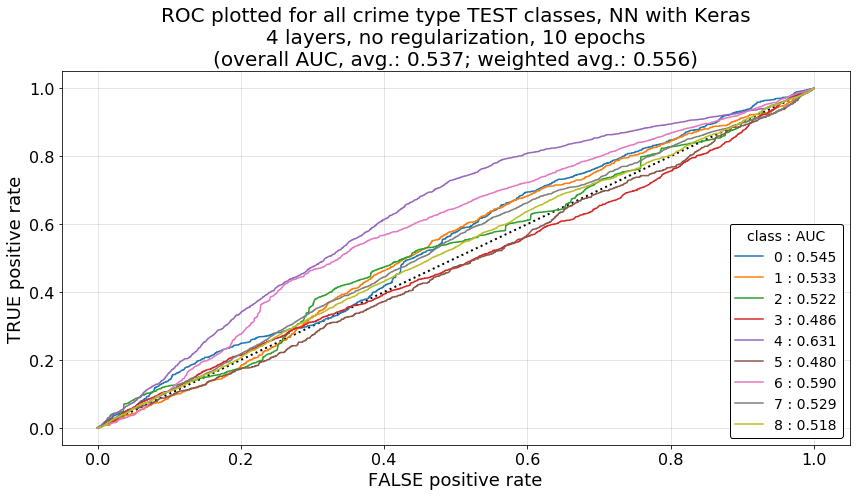

In [106]:
title = 'ROC plotted for all crime type TEST classes, NN with Keras\n'\
        '4 layers, no regularization, 10 epochs'
savepath = os.path.join(FIGURES_ROOT, 'roc-basic-nn.png')

plot_roc_all_classes(*auc_inputs, title, savepath)
